In [1]:
import pdfplumber
import fitz  # PyMuPDF
import base64
from IPython.display import display, Image as IPImage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import os 
from dotenv import load_dotenv
import nest_asyncio
from pathlib import Path
from openai import OpenAI
import contextlib
import logging

current_directory = os.getcwd()
print("Current Directory:", current_directory)  # พิมพ์ที่อยู่ปัจจุบัน

# ปรับเส้นทางไปยังไฟล์ .env ในโฟลเดอร์ venv
env_path = Path(current_directory).parent.parent / 'venv' / '.env'
print("Env Path:", env_path)  # พิมพ์เส้นทางที่ไปยัง .env

load_dotenv(dotenv_path=env_path)


nest_asyncio.apply()

Current Directory: c:\Users\user\OneDrive\Desktop\Test_BOT_CSV\test\OCR
Env Path: c:\Users\user\OneDrive\Desktop\Test_BOT_CSV\venv\.env


In [2]:
# keys for the services we will use
OPENAI_API_KEY : str 
GROQ_API_KEY : str
LANGCHAIN_API_KEY : str
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')

In [4]:
# --------- อ่านข้อความและตารางจาก PDF ด้วย pdfplumber ---------
file_path = "./test_data/NIPS-2017-attention-is-all-you-need-Paper.pdf"
text_content = ""
tables_content = []

with pdfplumber.open(file_path) as pdf:
    for page_num, page in enumerate(pdf.pages, start=1):
        try:
            # อ่านข้อความ
            text = page.extract_text()
            if text:
                text_content += f"\n--- Page {page_num} ---\n{text}"
            
            # อ่านตาราง
            tables = page.extract_tables()
            if tables:
                for table in tables:
                    if table:  # ตรวจสอบว่าไม่ใช่ตารางเปล่า
                        tables_content.append(table)
        
        except Exception as e:
            print(f"❌ Error processing page {page_num}: {e}")
            
logging.getLogger("pdfminer").setLevel(logging.ERROR)  # ปิดคำเตือนที่บอก หน้านั้นใน PDF ไม่ได้กำหนด CropBox เอาไว้ → เลยใช้ MediaBox แทนเพื่อคำนวณขนาดและตำแหน่งในการตัดข้อมูล

In [6]:
# --------- ดึงรูปภาพจาก PyMuPDF ---------
doc = fitz.open(file_path)
image_dir = "extracted_images"
os.makedirs(image_dir, exist_ok=True)

images_b64 = []

for page_index in range(len(doc)):
    page = doc.load_page(page_index)
    images = page.get_images(full=True)
    
    for img_index, img in enumerate(images):
        xref = img[0]
        base_image = doc.extract_image(xref)
        image_bytes = base_image["image"]
        image_ext = base_image["ext"]
        image_filename = f"page{page_index+1}_img{img_index+1}.{image_ext}"
        image_path = os.path.join(image_dir, image_filename)
        
        with open(image_path, "wb") as f:
            f.write(image_bytes)
        
        images_b64.append(base64.b64encode(image_bytes).decode("utf-8"))

print(f"พบรูปภาพจำนวน: {len(images_b64)}")

พบรูปภาพจำนวน: 3


In [7]:
# --------- การแสดงผลภาพ ---------
def display_base64_image(base64_code):
    image_data = base64.b64decode(base64_code)
    display(IPImage(data=image_data))

# change index look another image
# display_base64_image(images_b64[1])    

In [8]:
client = OpenAI(api_key=OPENAI_API_KEY)

image_b64 = images_b64[2]

prompt = """
กรุณาวิเคราะห์และอธิบายภาพด้านล่างอย่างละเอียด โดยเน้นการนำเสนอในเชิงวิชาการ เพื่อให้เหมาะสมสำหรับการนำไปใช้ในเอกสารวิจัยหรือเอกสารวิชาการทั่วไป

ข้อกำหนดการอธิบาย:
1. วิเคราะห์องค์ประกอบที่ปรากฏในภาพอย่างละเอียด ทั้งในเชิงโครงสร้าง เนื้อหา และความสัมพันธ์ของข้อมูล
2. หากภาพนั้นเป็นกราฟหรือแผนภูมิ ให้ระบุข้อมูลที่ปรากฏบนแกน X และแกน Y อย่างชัดเจน แต่หากไม่มีแกนดังกล่าว สามารถข้ามข้อนี้ได้
3. อธิบายลำดับความสัมพันธ์ของข้อมูลหรือองค์ประกอบต่าง ๆ โดยนำเสนอในรูปแบบลำดับขั้นตอน (Step-by-step) เริ่มจากองค์ประกอบหลักก่อน แล้วจึงอธิบายองค์ประกอบรองตามลำดับ
4. ต้องเขียนด้วยข้อความธรรมดาเท่านั้น ห้ามใช้รูปแบบ Markdown เช่น การทำตัวหนา ตัวเอียง หรือการเน้นข้อความด้วยสัญลักษณ์พิเศษ เช่น ** ## * _
5. เนื้อหาต้องจัดเรียงให้อ่านง่าย ชัดเจน เป็นระบบ และมีความต่อเนื่องของตรรกะ
6. ใช้ภาษาทางวิชาการที่สุภาพ ถูกต้อง และสมบูรณ์ เหมาะสมสำหรับการนำไปใช้อ้างอิงในงานวิจัยหรือเอกสารวิชาการในทุกสาขา

หมายเหตุ: คำอธิบายควรมีความละเอียด ครอบคลุม และคำนึงถึงความสมบูรณ์ของเนื้อหาเป็นสำคัญ
"""

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_b64}"
                    }
                }
            ]
        }
    ],
    temperature=0.5
)

# แสดงผลลัพธ์
print(response.choices[0].message.content)

ภาพที่นำเสนอเป็นแผนภาพที่แสดงขั้นตอนการประมวลผลในโมเดลการเรียนรู้เชิงลึก โดยเฉพาะในบริบทของกลไกการให้ความสนใจ (Attention Mechanism) ในโมเดล Transformer ซึ่งมีความสำคัญในการประมวลผลข้อมูลที่เป็นลำดับ เช่น ข้อความหรือเสียง

1. **องค์ประกอบหลัก**: 
   - แผนภาพนี้ประกอบด้วยองค์ประกอบหลักสามส่วน ได้แก่ MatMul, SoftMax, Mask (opt.), Scale และ Q, K, V ซึ่งเป็นตัวแทนของข้อมูลที่ใช้ในกระบวนการประมวลผล
   - MatMul (Matrix Multiplication) ปรากฏในสองจุดในภาพ ซึ่งแสดงถึงการคูณเมทริกซ์ระหว่าง Q (Query) และ K (Key) ที่มีเป้าหมายเพื่อคำนวณคะแนนความสนใจ

2. **การวิเคราะห์ลำดับขั้นตอน**:
   - ขั้นตอนแรกเริ่มจากการคูณเมทริกซ์ระหว่าง Q และ K ผ่าน MatMul ซึ่งจะให้ผลลัพธ์เป็นคะแนนที่แสดงถึงความสัมพันธ์ระหว่างข้อมูล
   - จากนั้น ผลลัพธ์นี้จะถูกส่งไปยังขั้นตอน Scale ซึ่งมีหน้าที่ในการปรับขนาดของคะแนนเพื่อให้การคำนวณมีความเสถียรและหลีกเลี่ยงปัญหาค่ามากเกินไป
   - หลังจากนั้น ผลลัพธ์ที่ปรับขนาดแล้วจะถูกส่งไปยัง SoftMax ซึ่งทำหน้าที่แปลงคะแนนให้เป็นความน่าจะเป็น โดยการใช้ฟังก์ชัน SoftMax เพื่อให้ผลลัพธ์มีค่ารวมก

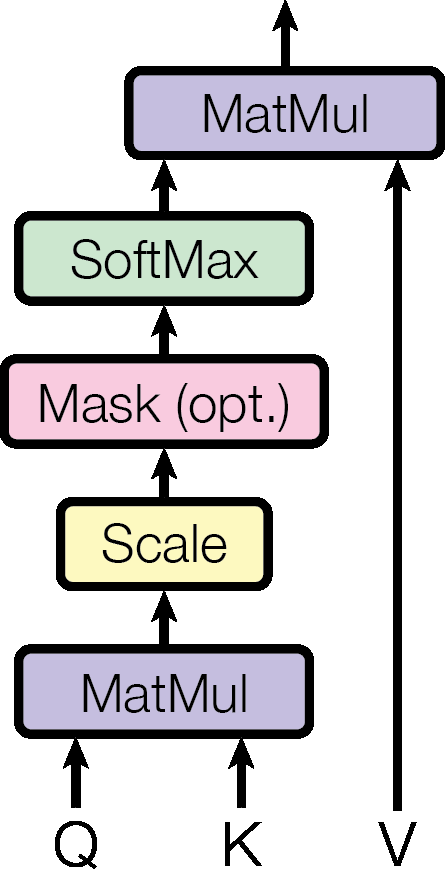

In [9]:
display_base64_image(images_b64[2])